In [11]:
%matplotlib inline
# %matplotlib qt
import matplotlib.pyplot as plt
import pickle
import numpy as np
from sklearn.neighbors import NearestNeighbors
import sklearn.neighbors._unsupervised
from draw_utils import draw_3d_clusters, draw_spiral_clusters
from matplotlib.ticker import LogFormatterExponent
plt.rcParams['figure.figsize'] = [15, 10]

In [69]:
with open('./saved/ckpt.pickle', 'rb') as f:
    x = pickle.load(f)
x.keys()

dict_keys(['knn', 295, 290, 285, 280, 275, 270, 265, 260, 255, 250, 245, 240, 235, 230, 225, 220, 215, 210, 205, 200, 195, 190, 185, 180, 175, 170, 165, 160, 155, 150, 145, 140, 135, 130, 125, 120, 115, 110, 105, 100, 95, 90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5])

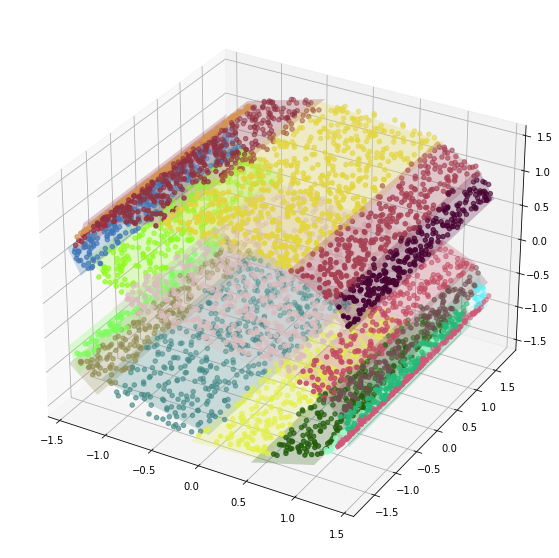

In [71]:
k = 20
C = x[k]['C']
if C[0].X[0].shape[0] == 2:
    draw_spiral_clusters(C, k=x['knn'])
elif C[0].X[0].shape[0] == 3:
    draw_3d_clusters(C)

In [53]:
k = 198
C = x[k]['C']
knn = x[k]['knn']
Ci = C[-1]
print(len(Ci.points))
[knn.kneighbors(Ci.X)[1][0, 2] in Cj.indices for Cj in C]

KeyError: 198

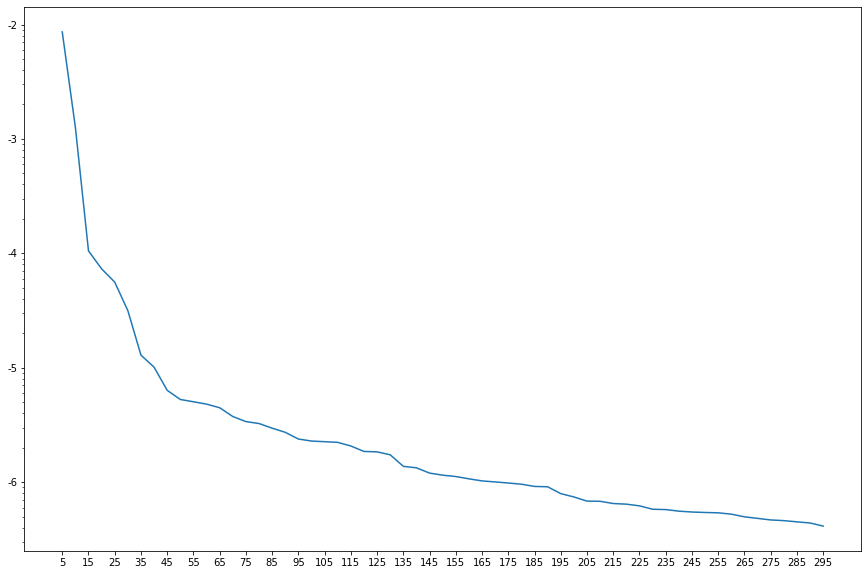

In [75]:
errors = {}
for it in x.keys():
    if it == 'knn':
        continue
        
    e = []
    C = x[it]['C']
    for Ci in C:
        F = Ci.F
        P = np.dot(F, F.T)
        samples = np.array(Ci.X).T
        mean_pos = np.mean(samples, axis=1, keepdims=True)
        s = samples - mean_pos

        proj = np.dot(P, s)
        e.append((s - proj)**2)
    errors[it] = np.mean(np.concatenate(e, axis=1), axis=(0, 1))

plt.semilogy(list(errors.keys()), list(errors.values()))
ax = plt.gca()
plt.xticks(list(errors.keys())[::3])
ax.yaxis.set_major_formatter(LogFormatterExponent())
plt.show()